# ECSE 415 - Final Project
### Philippe Sarouphim Hochar 260885492
### Joseph Saliba 260975670

In this project, we are interested in analyzing dashcam footage from cars. Specifically, we are interersted in counting the number of parked cars, moving cars, and pedestrians that were passed.

Though relatively simple, this project implements some of the basic functionalities that could be found in self-driving cars, and provides us with additional insights into the world of computer vision.

In this notebook we will be going over the approach we took to solve the problem, explanations of relevant code sections, results, performance analysis, and comparison with ground truth. Additionally, we discuss the problems we encountered with our solution, and potential future works to improve the software.

## Our Solution

Our problem can de divided into three parts.

1. Object detection and classicication.
2. Object tracking.
3. Differentiating between parked cars, cars moving in the same direction, and cars moving in the opposite direction.

The explanation for how we solved each part can be found below in the notebook.

## Setup
We start by importing the relevant libraries
- numpy (v1.23.3)
- matplotlib (v3.5.1)
- cv2 (v4.8.1.78)
- scikit-learn (v1.1.3)
- pickle (included with python interpreter)

Additionally, we import some types for type-hinting purposes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from sklearn.cluster import MeanShift, estimate_bandwidth

# Type hinting
from typing import Generator
from cv2.typing import MatLike

Next, we define a `PATH` variable that points to the repository. Every memory access in the code will be relative to that variable.

We also define a few functions that will be useful throughout the code:
- `showImages`: This function displays a grid of images with their titles.
- `showGSImages`: This function displays a grid of grayscale images with their titles.

In [2]:
PATH = "./"

np.set_printoptions(edgeitems=24)

def showImages(images: list[list[MatLike]], titles: list[list[str]]):
    """
    This function takes a 2D array of images and titles and displays them in the notebook in color.

    ---

    Parameters
    ----------
    `images`: `list[list[MatLike]]`
        2D grid of images to be displayed.
    
    `titles`: `list[list[str]]`
        2D grid of titles that correspond to each image. It must have the same shape as the `images`
        grid.
    """
    
    rows = len(images)
    cols = len(images[0])
    fig = plt.figure(figsize=(cols * 7 if cols > 1 else 25, rows * 5 if rows > 1 else 10))

    # Add every picture in the plot
    for i in range(rows):
        for j in range(cols):
            if images[i][j] is None: continue
            fig.add_subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i][j][:,:,::-1])
            plt.axis('off')
            plt.title(titles[i][j])
    
    plt.show()


def showGSImages(images, titles, cmap=[]):
    """
    This function takes a 2D array of grayscale images and titles and displays them in the notebook.

    ---

    Parameters
    ----------
    `images`: `list[list[MatLike]]`
        2D grid of grayscale images to be displayed.
    
    `titles`: `list[list[str]]`
        2D grid of titles that correspond to each image. It must have the same shape as the `images`
        grid.
    """

    rows = len(images)
    cols = len(images[0])
    fig = plt.figure(figsize=(cols * 7 if cols > 1 else 12, rows * 5))

    # Add every picture in the plot
    for i in range(rows):
        for j in range(cols):
            if images[i][j] is None: continue
            fig.add_subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i][j], cmap=cmap[i][j] if len(cmap) != 0 else 'gray')
            plt.axis('off')
            plt.title(titles[i][j])
    
    plt.show()


### Video Reader

We define a `VideoReader` class that helps with reading video from the filesystem.

It is based on OpenCV's `VideoCapture` class, and helps with reading the frames of a video, as well as getting information such as the frame dimension and the FPS value.

The main purpose of this class is to wrap the functionalities needed to read every nth frame of a video using the `VideoReader.frames(n)` function.

In [3]:
class VideoReader():
    """
    A class used to read videos from the filesystem.
    
    ---

    Attributes
    ----------
    `filename` : `str`
        A string pointing to the path of the video in the file system.
    
    `cap` : `VideoCapture`
        The underlying OpenCV `VideoCapture` that helps read the video file.

    `framewidth` : `int`
        An integer indicating the width of the frames in the video.

    `frameheight` : `int`
        An integer indicating the height of the frames in the video.
    
    `fps` : `float`
        A floating-point number indicating the framerate of the video.

    ---

    Methods
    -------
    `getInfo() -> (int, int, float)`
        Get basic information about the video: frame width, frame height, frame rate.

    `frames(freq: int) -> Generator[MatLike, None, None]`
        Generator function that yields every nth frame.
    
    `getFrame(n: int) -> MatLike`
        Reads and returns frame `n` of the video.

    `release()`
        Video capture release.
    """
    
    def __init__(self, filename: str):
        # Open video
        self.cap = cv2.VideoCapture(filename)

        # Ensure video was correctly opened or raise exception
        if(self.cap.isOpened() == False):
            raise SystemExit("Error opening video file!")
        
        # Get basic information of video
        self.frame_width = int(self.cap.get(3))
        self.frame_height = int(self.cap.get(4))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
    
    
    def getInfo(self) -> (int, int, float):
        """
        Get basic information about the video: frame width, frame height, frame rate.

        ---

        Returns
        -------
        `int`
            Frame width

        `int`
            Frame height
            
        `float`
            Frame rate
        """
        return self.frame_width, self.frame_height, self.fps
    

    def frames(self, freq: int) -> Generator[MatLike, None, None]:
        """
        Generator function that yields every nth frame of the video.

        ---

        Parameters
        ----------
        `freq`: `int`
            Integer representing the number of frames to skip before yielding the next one.
        
        ---

        Yields
        ------
        `MatLike`
            Next frame of the video.
        """
        i = 0
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            
            # If end of video is reached, exit the generator loop
            if ret == False: break

            i += 1
            # Skip frame if its index is not a multiple of freq
            if i % freq != 0: continue

            yield frame

    
    def getFrame(self, n: int) -> MatLike:
        """
        Reads and returns frame `n` of the video.

        ---

        Parameters
        ----------
        `n`: `int`
            Index of the frame to return.
        
        ---

        Returns
        -------
        `MatLike`
            Frame `n` of the video.
        """
        # Set index of the next frame to load
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, n)

        # Load frame
        ret, frame = self.cap.read()

        # Return frame if exists or None
        if ret == False: return None
        return frame
        
    
    
    def release(self):
        """
        Function that releases the `VideoCapture` element that helped read the video.
        """
        self.cap.release()

## 1. Object Detection and Classification

The first part of our project is to perform object detection and classification on every frame of the video.

To do so, we use the YOLOv3 model pretrained on the COCO dataset. We choose the COCO dataset as it contains the relevant classes we need for this project.

We wrap all the functionalities related to the model in a `Yolo` class. This includes, loading the pretrained model, and exposing the functions to process an image in the network, and to get the resulting bounding boxes. We also add a function to draw the bounding boxes on a frame.

Additionally, we develop a simple `BoundingBox` class that contains the bounding box position and size. It also contains methods that help with computing the distance between bounding boxes and to get the coordinates of the lower-right corner.

In [4]:
class BoundingBox():
    """
    A class that is used to represent a bounding box detected by object detector models.

    ---

    Attributes
    ----------
    `x`: `float`
        Float representing the x-coordinate of the top-left corner of the bounding box.
    
    `y`: `float`
        Float representing the y-coordinate of the top-left corner of the bounding box.
    
    `w`: `float`
        Float representing the width of the bounding box.
    
    `h`: `float`
        Float representing the height of the bounding box.
    
    `clazz`: `int`
        Class ID of the detected object.
    
    `confidence`: `float`
        Float between 0 and 1 representing the classification confidence of the object in the
        bounding box.
    
    `center_x`: `float`
        Float representing the x-coordinate of the center point of the bounding box.
    
    `center_y`: `float`
        Float representing the y-coordinate of the center point of the bounding box.
    
    ---

    Methods
    -------
    `get_distance(other: BoundingBox)`
        This function computes the distance between the center point of this bounding box and the
        center point of another bounding box.
    
    `get_top_left_corner() -> (int, int)`
        This function returns a tuple holding the rounded coordinates of the top-left corner of the
        bounding box.
    
    `get_lower_right_corner() -> (int, int)`
        This function returns a tuple holding the rounded coordinates of the lower-right corner of
        the bounding box.
    """
    
    def __init__(self, x: float, y: float, w: float, h: float, clazz: int, confidence: float):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.clazz = clazz
        self.confidence = confidence

        # Compute center coordinates of the bounding box
        self.center_x = x + w / 2
        self.center_y = y + h / 2
    

    def get_distance(self, other: "BoundingBox") -> float:
        """
        This function computes the distance between the center point of this bounding box and the
        center point of another bounding box.

        ---

        Parameters
        ----------
        `other`: `BoundingBox`
            The other bounding box with which to compute the distance.
        
        ---

        Returns
        -------
        `float`
            Distance between this bounding box and the other.
        """
        return np.sqrt((self.center_x - other.center_x) ** 2 + (self.center_y - other.center_y) ** 2)


    def get_top_left_corner(self) -> (int, int):
        """
        This function returns a tuple holding the rounded coordinates of the top-left corner of the
        bounding box.

        ---

        Returns
        -------
        `(int, int)`
            Tuple of the rounded coordinates (x, y) of the top-left corner of the bounding box.
        """
        return (round(self.x), round(self.y))
    

    def get_lower_right_corner(self) -> (int, int):
        """
        This function returns a tuple holding the rounded coordinates of the lower-right corner of 
        the bounding box.

        ---

        Returns
        -------
        `(int, int)`
            Tuple of the rounded coordinates (x, y) of the lower-right corner of the bounding box.
        """
        return (round(self.x + self.w), round(self.y + self.h))

In [5]:
class Object():
    """
    A class that represents an object in the video.

    ---

    Attributes
    ----------
    `id`: `int`
        Unique ID of the object in the video.
    
    `bounding_box`: `BoundingBox`
        The bounding box of the object in the video. This is updated every frame.
    
    `absent_frames`: `int`
        The number of frames since the object disappeared from the scene.

    `distance_from_origin`: `float`
        The distance of the object from the frame center.
    """

    def __init__(self, id: int, bounding_box: BoundingBox):
        self.id = id
        self.bounding_box = bounding_box
        self.distance_from_origin = np.sqrt((self.bounding_box.center_x - 2562/2) ** 2 + (self.bounding_box.center_y - 1440/2) ** 2)
        self.absent_frames = 0

    def __str__(self) -> str:
        return f"#{self.id} ({self.bounding_box.center_x}, {self.bounding_box.center_y})"


In [6]:
class Yolo:
    """
    A class that contains a YOLOv3 model pretrained on the COCO dataset.
    It wraps the functionalities to process a picture on this model and retrieve the bounding boxes
    of the detected and classified objects.

    ---

    Attributes
    ----------
    `yolov3`: `Net`
        YOLOv3 neural network pretrained on the COCO dataset.

    `classes`: `list[str]`
        List of classes that can be classified by the model.
    
    `colors`: `ndarray[Any, dtype[float64]]`
        Randomly-generated RGB tuples list where each tuple represents the color associated to a
        class. For the purposes of drawing the bounding boxes.
    
    ---

    Methods
    -------
    `process_frame(frame: MatLike) -> list[BoundingBox]`
        This function processes an image using the model and returns a list of the resulting
        bounding boxes.
    
    `draw_bounding_box(img: MatLike, obj: Object)`
        This function draws a given object and its associated bounding box on a given image.
    """
    
    def __init__(self):
        # Import Darknet Yolov3 CNN from file as well as weights from COCO pretraining
        self.yolov3 = cv2.dnn.readNet(PATH + "/data/yolov3.weights", PATH + "/data/yolov3.cfg")

        # Import COCO classes from file
        self.classes = []
        classes_file = open(PATH + "/data/yolov3.classes", "r")
        for l in classes_file.readlines():
            self.classes.append(l.strip())

        # Generate random colors for each class to draw bounding boxes
        self.colors = np.random.uniform(0, 255, size=(len(self.classes), 3))
    
    
    def process_frame(self, frame: MatLike) -> list[BoundingBox]:
        """
        This function processes an image using the model and returns a list of the resulting
        bounding boxes.

        ---

        Parameters
        ----------
        `frame`: `MatLike`
            Image to be processed by the model.
        
        ---

        Returns
        -------
        `list[BoundingBox]`
            The list of bounding boxes found by the model.
        """
        frame_blob = cv2.dnn.blobFromImage(frame, 0.00392, (416,416), (0,0,0), True, crop=False)

        # Execute neural network with image as input
        self.yolov3.setInput(frame_blob)
        output = self.yolov3.forward()

        class_ids = []
        confidences = []
        boxes = []

        CONF_THRESH = 0.5
        # Extract data from output matrix
        for o in output:
            # Get predicted class and confidence for bounding box
            scores = o[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Consider bounding box only if confidence is above threshold value
            if confidence > CONF_THRESH:
                center_x = int(o[0] * frame.shape[1])
                center_y = int(o[1] * frame.shape[0])
                w = int(o[2] * frame.shape[1])
                h = int(o[3] * frame.shape[0])
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

        # Apply non-max suppression
        NMS_THRESH = 0.4
        indices = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRESH, NMS_THRESH)

        # Create the bounding box objects
        bounding_boxes = []
        for idx in indices:
            bounding_boxes.append(BoundingBox(boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3], class_ids[idx], confidences[idx]))

        return bounding_boxes


    # function to draw bounding box on the detected object with class name
    def draw_bounding_box(self, img: MatLike, obj: Object):
        """
        This function draws a given object and its associated bounding box on a given image.

        ---

        Parameters
        ----------
        `img`: `MatLike`
            Image on which to draw the object and its bounding box.
        
        `obj`: `Object`
            Object to draw on the image.
        """
        label = "{} {} (#{})".format(self.classes[obj.bounding_box.clazz], round(obj.bounding_box.confidence, 2), obj.id)
        color = self.colors[obj.bounding_box.clazz]
        cv2.rectangle(img, obj.bounding_box.get_top_left_corner(), obj.bounding_box.get_lower_right_corner(), color, 2)
        cv2.putText(img, label, (round(obj.bounding_box.x - 10), round(obj.bounding_box.y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

## 2. Object Tracking

Next, we need to implement an object tracking algorithm to match the bounding boxes of subsequent frames that correspond to a same object.

To do so, we start by defining an `Object` class which holds a unique ID, a bounding box, and other relevant information. On each new frame, if we find a bounding box to match one of the previous frames', we simply update the bounding box of said object, instead of creating a new object.

Next, we define an `Objects` class. The purpose of this class is to hold all of the objects that are present in the scene. On every frame, we compute the bounding boxes as explained above, and we then feed them to our `Objects` instance by passing them to the `addFrame` method. In turn, this method will compute any matches between the old and the new bounding boxes, update the existing objects, remove the ones that disappeared, and create the new ones.

### Tracking algorithm
To perform tracking, we start by computing the distances between all previous and all new bounding boxes of the same class (brute-force).

We then sort the distances in ascending order.

We iterate over all of the computed distances, adding each pair to our list of matches, ensuring no bounding box is counted in more than one match.

However, if a certain object disappeared, and a new one appeared in the subsequent frame, they might be matched together, even if the distance between them is big, as they do not have a better match. Therefore, we define a `DISTANCE_THRESHOLD` parameter, that if exceeded, we consider the pair of bounding boxes not to be a match.

Lastly, it is common for an object to not be detected for a few frames, then be detected again. With our algorithm, this will result in the item disappearing, and then a new object being created when it reappears. To deal with this problem, we define another parameter for our algorithm: `MAX_ABSENT_FRAMES`. This parameters will allow an object to be absent for a certain amount of frames before removing it from the objects list.

In [7]:
DISTANCE_THRESHOLD = 75
MAX_ABSENT_FRAMES = 5

class Objects():
    """
    A class that contains the objects present in the scene and the necessary logic to track objects
    across frames.

    ---

    Attributes
    ----------
    `idx`: `int`
        Integer iterator that tracks the next unique ID that can be given to a new object.
    
    `objects`: `dict[int, list[Object]]`
        Dictionary contianing lists of objects categorized by their class.
    
    ---

    Methods
    -------
    `add_frame(bbs: list[BoundingBox])`
        This function takes in the bounding boxes of the next frame and matches the existing objects
        to the new bounding boxes. It updates the the matched objects, creates new objects for new
        bounding boxes, and removes objects that no longer exist, when appropriate.
    
    `compute_distances(clazz: int, bbs: list[BoundingBox]) -> dict[tulpe[Object, BoundingBox], float]`
        This function computes all the distances between the objects in the class's dictionary that
        correspond to the input class ID, and the input bounding boxes.
    
    `match_bounding_boxes(distances: dict[tuple[Object, BoundingBox], float]) -> (list[tuple[Object, BoundingBox]], list[Object], list[BoundingBox])`
        This function finds the matches between the existing objects in the scene and the input
        bounding boxes.
    
    `next_id() -> int`
        This function increments `idx` and returns the new value. This serves when creating a new
        object.
    
    `get_all_objects() -> list[Object]`
        This function returns a list of all objects in the scene by flattening the dictionary
        values.
    """

    def __init__(self):
        self.idx = -1
        self.objects: dict[int, list[Object]] = dict({})


    def add_frame(self, bbs: list[BoundingBox]):
        """
        This function takes in the bounding boxes of the next frame and matches the existing objects
        to the new bounding boxes. It updates the the matched objects, creates new objects for new
        bounding boxes, and removes objects that no longer exist, when appropriate.

        ---

        Parameters
        ----------
        `bbs`: `list[BoundingBox]`
            The new bounding boxes found in the next frame.
        """
        # For each objects of a given class
        for c in self.objects.keys():
            # Find the matches with the new bounding boxes
            bbs_c = list(filter(lambda bb: bb.clazz == c, bbs))
            distances = self.compute_distances(c, bbs_c)
            matches, used_objs, used_bbs = self.match_bounding_boxes(distances)

            # Eliminate matches that excees the distance threshold
            for match in matches:
                if distances[match] > (match[0].absent_frames + 1) * DISTANCE_THRESHOLD:  # multiply by sizes
                    used_objs.remove(match[0])
                    used_bbs.remove(match[1])
                    matches.remove(match)

            # Increment the absent_frames attribute of all objects that do not appear in the new
            # frame
            for obj in self.objects[c]:
                if not obj in used_objs:
                    obj.absent_frames += 1

                    if obj.absent_frames > MAX_ABSENT_FRAMES:
                        self.objects[c].remove(obj)
            
            # Create a new object for every bounding box that was not present in the previous frames
            for bb in bbs_c:
                if not bb in used_bbs:
                    self.objects[c].append(Object(self.next_id(), bb))

            # Update the bounding boxes of the matched objects
            for match in matches:
                match[0].bounding_box = match[1]
                match[0].absent_frames = 0
        
        # For every bounding box whose class was not previously present in the dictionary:
        # 1. Add a new list entry to the dictionary
        # 2. Create a new object for the bounding box
        # 3. Append the new object to the dictionary
        for bb in list(filter(lambda bb: (not bb.clazz in self.objects), bbs)):
            if bb.clazz not in self.objects: self.objects[bb.clazz] = []
            self.objects[bb.clazz].append(Object(self.next_id(), bb))


    def compute_distances(self, clazz: int, bbs: list[BoundingBox]) -> dict[tuple[Object, BoundingBox], float]:
        """
        This function computes all the distances between the objects in the class's dictionary that
        correspond to the input class ID, and the input bounding boxes.

        ---

        Parameters
        ----------
        `clazz`: `int`
            Class ID whose objects to get from the class's dictionary.
        
        `bbs`: `list[BoundingBox]`
            Bounding boxes to compute the distances with. These should also be of the class `clazz`.
        
        ---

        Returns
        -------
        `dict[tuple[Object, BoundingBox], float]
            Dictionary mapping each object-bounding box pair to the distance that separates them.
        """
        distances: dict[tuple[Object, BoundingBox], float] = dict({})

        # Compute distances between all objects and all bounding boxes
        for obj in self.objects[clazz]:
            for bb in bbs:
                distances[(obj, bb)] = obj.bounding_box.get_distance(bb)

        return distances


    def match_bounding_boxes(self, distances: dict[tuple[Object, BoundingBox], float]) -> (list[tuple[Object, BoundingBox]], list[Object], list[BoundingBox]):
        """
        This function finds the matches between the existing objects in the scene and the input
        bounding boxes.

        ---

        Parameters
        ----------
        `distances`: `dict[tuple[Object, BoundingBox], float]`
            Dictionary mapping each object-bounding box pair to the distance that separates them.
        
        ---

        Returns
        -------
        `list[tuple[Object, BoundingBox]]`
            List of object-bounding box pairs representing the matches. Each object and bounding box
            appears only once in the list.
        
        `list[Object]`
            List of matched objects.

        `list[BoundingBox]`
            List of matched bounding boxes.
        """
        # Sort the distances dictionary
        sorted_keys = list(sorted(distances, key=distances.get))

        mutex_keys = []
        used_objs = set([])
        used_bbs = set([])
        for k in sorted_keys:
            # If object or bounding box is already match, skip entry
            if k[0] in used_objs or k[1] in used_bbs: continue

            # Mark the matched object and bounding box as used
            used_objs.add(k[0])
            used_bbs.add(k[1])

            # Append the pair to the list of matches
            mutex_keys.append(k)

        return mutex_keys, used_objs, used_bbs


    def next_id(self) -> int:
        """
        This function increments `idx` and returns the new value. This serves when creating a new
        object.

        ---

        Returns
        -------
        `int`
            The unique ID to use for the new object.
        """
        self.idx += 1
        return self.idx
    

    def get_all_objects(self) -> list[Object]:
        """
        This function returns a list of all objects in the scene by flattening the dictionary
        values.

        ---

        Returns
        -------
        `list[Object]`
            The list of all objects in the scene.
        """
        return  [value for sublist in self.objects.values() for value in sublist]
    

    def copy(self):
        """
        This function returns a copy of the current `Objects` instance.

        ---

        Returns
        -------
        `Objects`
            A copy of the current `Objects` instance.
        """
        new_objects = Objects()
        new_objects.idx = self.idx
        new_objects.objects = {
            key: [Object(obj.id, obj.bounding_box) for obj in value]
            for key, value in self.objects.items()
        }

        return new_objects
    
    def __str__(self):
        return str(list(tuple([key, [str(obj) for obj in value]]) for key, value in self.objects.items())) + "\n"


We now proceed to apply all of the object detection, classification, and tracking using the funciton defined below.

We do so, for both videos, and save our output for debugging purposes.

In [8]:
def apply_YOLO_with_tracking(video_name: str):
    """
    This function applies the YOLOv3 model to a video and saves the output video with the bounding.
    While doing so, it also tracks the objects in the scene and assigns them unique IDs.
    The function also saves the list of objects per frame to a file.

    ---
    Attributes

    `video_name`: `str`
        The name of the video file to process.
    """
    # Create an instance of the model
    yolo = Yolo()

    # Create the video reader
    video_in = VideoReader(PATH + "/data/" + video_name)
    # Get basic information on video and print them
    frame_width, frame_height, fps = video_in.getInfo()
    print("Frame dimensions: ({}, {})".format(frame_width, frame_height))
    print("FPS: {}".format(fps))

    # Create the output video stream
    out = cv2.VideoWriter(PATH + "/out/" + video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))

    # Create the object that holds all objects in the scene
    objects = Objects()

    # Create a list of objects per frame
    frames_objects_dict : list[Objects] = []

    # Loop over every frame
    for frame_i in video_in.frames(1):
        # Process frame and process new bounding boxes for tracking
        bounding_boxes = yolo.process_frame(frame_i)
        objects.add_frame(bounding_boxes)

        frames_objects_dict.append(objects.copy())

        # Draw each object on the frame picture
        for obj in objects.get_all_objects():
            yolo.draw_bounding_box(frame_i, obj)

        # Write the new frame picture with bounding boxes to the output video
        out.write(frame_i)

    # save objects_per_frame list to file
    with open(PATH + "/out/objects_" + video_name.split('.')[0] + ".bb", "wb") as f:
        pickle.dump(frames_objects_dict, f)


    # Release video streams
    video_in.release()
    out.release()

In [9]:
# Apply YOLOv2 and tracking to both videos
video_names = (
    "mcgill_drive.mp4",
    "st-catherines_drive.mp4"
)

In [10]:
for video_name in video_names:
    apply_YOLO_with_tracking(video_name)  # very long, takes 10 minutes

Frame dimensions: (2562, 1440)
FPS: 29.97002997002997
Frame dimensions: (2562, 1440)
FPS: 29.97002997002997


In [11]:
# read objects_per_frame list from file
def retrieve_objects_for_video(video_name: str) -> list[Objects]:
    """
    This function reads the list of objects per frame from a file.

    ---

    Attributes

    `video_name`: `str`
        The name of the video file to process.

    ---

    Returns
    -------
    `list[Objects]`
        The list of objects per frame.
    """
    with open(PATH + "/out/objects_" + video_name.split('.')[0] + ".bb", "rb") as f:
        frames_objects_dict: list[Objects] = pickle.load(f)

    print("Number of frames: {}".format(len(frames_objects_dict)))

    return frames_objects_dict


# Create a dictionary mapping video names to the list of objects per frame
video_frames_objects_dict : dict[str: list[Objects]] = {
    video_name: retrieve_objects_for_video(video_name)
    for video_name in video_names
}

Number of frames: 1071
Number of frames: 1477


# 3. Classifying cars by average speed
At this point we have the bounding boxes information of all objects. To determine if we have passed a car, and if it was moving or parked, we look at the average speed of the cars relative to the camera.

The reason for that is illustrated by the image below:

![Street Diagram & Average Speed of Cars](resources/street_diagram.drawio.png "Street Diagram & Average Speed of Cars")

Considering that the car in which the video is taken is referred to as **reference car**
The cars that we do not pass, which are moving in the same lane as the reference car will have a **low** average speed relative to the reference car, since the difference in velocity is very low. Applying the same concept, cars that are moving in the opposite lane of the reference car will have a large difference in directional velocity and will therefore have a **high** average speed relative to the reference car. Furthermore, parked cars will have a **medium** difference of speed.

It is therefore possible to classify a detected car into the classes ['Not passed', 'Passed Parked', 'Passed Moving'] using the average speed of the car.

The next step is therefore to calculate that average speed before applying a classification algorithm which we chose to be Meanshift clustering.

### Average Speed Calculation of Cars
The average speed is calculated as the displacement of each car's bounding box center averaged accross frames.
The displacement between a frame and its predecessor can be calculated using pythagoras using the bounding box's center x and y coordinate.

Lastly, since cars that are far move slower, while closer cars move faster compared to the reference car's video, we normalize the average speed calculation. To normalize it, we calculate the distance between the center of the frame and the car's bounding box, and divide the calculated speed by the sqrt of that distance.

The formula for the average speed for a car is therefore:

$$S_i = \left( \sum_{f=1}^{F} \frac{\sqrt{(x_f - x_{f-1}) ^ 2 + (y_f - y_{f-1}) ^ 2}}{\sqrt{d_f}} \right) /{F}$$

Where $f$ is frame index and $F$ is the total number of frames. $x_f$ and $y_f$ respectively represen  the x and y coordinates of the car as seen in the video at frame $f$, and $S_i$ represents the average seed of car $i$.

It should also be noted that we drop objects with less than 20 frames of screentime to ensure that "real" objects only are considered in the calculation and classification.

We implement the calculation in the class `ObjectTracker` below.


In [12]:
CARS_CLASS_ID = 2
PEDESTRIANS_CLASS_ID = 0

class ObjectTracker():
    """
    A class that tracks the position of an object across frames.
    Performs the computation of the average speed of the object.

    ---

    Attributes
    ----------
    `clazz`: `int`
        The class ID of the object.

    `frames_pos_dict`: `dict[int, tuple[int, int, float]]`
        Dictionary mapping frame indices to tuples of the object's position and position from frame origin.

    `displacement`: `float`
        The displacement of the object across frames.
    ---
    """


    def __init__(self, clazz: int, frames_pos_dict: dict[int, tuple[int, int, float]]) -> None:
        self.clazz: int = clazz
        self.frames_pos_dict: dict[int, tuple[int, int]] = frames_pos_dict
        self.displacement: float = -1


    def compute_displacement(self):
        """
        This function computes the displacement of the object across frames.
        """
        if len(self.frames_pos_dict) < 2:
            self.displacement = 0
            return

        self.displacement = 0
        prev_pos = None
        for frame, pos in self.frames_pos_dict.items():
            if prev_pos is None:
                prev_pos = pos
                continue

            self.displacement += np.sqrt((pos[0] - prev_pos[0]) ** 2 + (pos[1] - prev_pos[1]) ** 2) / (pos[2])**0.5
            prev_pos = pos

        self.displacement /= max(self.frames_pos_dict.keys()) - min(self.frames_pos_dict.keys())  # calculate mean (divide sum by number of frames)

        # normalize displacement to [0, 100]


    def __str__(self) -> str:
        return str(self.frames_pos_dict)


def compute_video_objects_displacement(frames_objects_dict: list[Objects]) -> dict[int, ObjectTracker]:
    """
    This function computes the displacement of the objects in the scene across frames.

    ---
    Attributes

    `frames_objects_dict`: `list[Objects]`
        The list of objects per frame.

    ---

    Returns

    `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.

    """
    # create a dictionary of objects position across frames
    objects_position : dict[int, ObjectTracker] = dict({})

    for frame_i, objects in enumerate(frames_objects_dict):
        for obj in objects.get_all_objects():
            if obj.id not in objects_position:
                objects_position[obj.id] = ObjectTracker(obj.bounding_box.clazz, dict({}))
            objects_position[obj.id].frames_pos_dict[frame_i] = (obj.bounding_box.center_x, obj.bounding_box.center_y, obj.distance_from_origin)

    for id, tracker in objects_position.items():
        tracker.compute_displacement()

    # drop objects with less than 20 frames tracked
    return {
        id: tracker for id, tracker in objects_position.items() if len(tracker.frames_pos_dict) > 20
    }

### Applying Meanshift Clustering
Now that we have the relative average speed informations of all car objects in the video accross all frames, we want to classify the classes into the three possible classes:
- Not passed (low average speed)
- Passed parked (medium average speed)
- Passed moving (high average speed)

The first algorithm we tried was k-means clustering. While k-means clustering is a robust algorithm, it assumes we know `k`, the number of classes contained in the data. That was a problem for us, because while the `mcgill-drive` video contained data from all three classes, the `st-catherine-drive` video, which showcased the car driving through a one-way street, did not include any moving cars in the opposite direction (`passed moving` cars). The number of classes was therefore different in the data of both videos.

This caused the kmeans algorithm to fail on one of the two videos.

The solution to our problem was to use an algorithm which does not assume the number of classes in the data, but tries to infer it instead. Meanshift Clustering is such an algorithm. As seen in the results later in the document, Meanshift clustering was successfully able to predict the number of clusters for both videos.

To run Meanshift Clustering, we use `sklearn`'s `MeanShift` class. To run the algorithm, we require to calculate the bandwidth, which we do by using another function from `sklearn` with a quantile parameter. After running the algorithm multiple times, we found that the algorithm ran best with the quantile parameter set to `0.5`.

The implementation of the meanshift clustering is shown in the function below.

In [13]:
def apply_meanshift_clustering(objects_position: dict[int, ObjectTracker]) -> list[int]:
    """
    This function applies the MeanShift clustering algorithm to the objects in the scene.
    Also plots the displacements of the objects and prints the IDs of the objects as well as the regions.

    ---

    Attributes
    ----------
    `objects_position`: `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.

    ---
    
    Returns
    -------
    `list[int]`
        List of sorted cluster centerss
    """
    car_trackers_displacement = [tracker.displacement for tracker in objects_position.values() if tracker.clazz == CARS_CLASS_ID]

    # use 1D meanshift to cluster the displacements
    X = np.array(car_trackers_displacement).reshape(-1, 1)
    bandwidth = estimate_bandwidth(X, quantile=0.5)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    cluster_centers = sorted(ms.cluster_centers_)

    return cluster_centers

## Displaying Results

In the next code cell we define three functions that help us display the results we obtained.

First, we have the `show_clustering` function that plots the different cars' speeds and shows the cluster division lines that were computed using mean-shift clustering.

Next, we have a `get_passed_objects_data` function that divides the objects into different lists based on the clustering, and appends relevant information for each object.

Finally, we have a `display_frame_with_data` function that displays a certain frame of a video, with bounding boxes, and prints the clustered object's information below it. This serves purely to showcase that our program works using one frame as example.

In [14]:
def show_clustering(cluster_centers: list[int], objects_position: dict[int, ObjectTracker]):
    """
    This function shows the clustering in a plot. It shows the separations as well as where each car
    falls onthe cluster.

    ---

    Parameters
    ----------
    `cluster_centers`: `list[int]`
        List of cluster center values
    
    `objects_position`: `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.
    """
    car_trackers_displacement = [tracker.displacement for tracker in objects_position.values() if tracker.clazz == CARS_CLASS_ID]

    # plot horizontal lines on the scatter representing the cluster centers
    plt.figure(figsize=(12, 8))
    plt.title(f"Average speed of cars of video '{video_name}'")
    plt.ylabel("Average Speed")
    plt.xticks([])

    plt.scatter(x=list(range(len(car_trackers_displacement))),y=car_trackers_displacement)

    # draw the ids of the objects
    i = 0
    for id, tracker in objects_position.items():
        if tracker.clazz == CARS_CLASS_ID:
            plt.annotate(id, (i, tracker.displacement))
            i += 1
    
    for i, line in enumerate(cluster_centers):
        plt.axhline(y=line, color='r', linestyle='-')
        conclusion = ""
        ycord = 0
        if i == 0:
            conclusion = "NOT PASSED"
            ycord = cluster_centers[0]/2
        if i == 1:
            conclusion = "PASSED PARKED"
            ycord = (cluster_centers[1] - cluster_centers[0]) / 2 + cluster_centers[0]
        if i == 2:
            conclusion = "PASSED MOVING"
            ycord = (cluster_centers[2] - cluster_centers[1]) / 2 + cluster_centers[1]

        plt.annotate(conclusion, (-1, ycord), color='r', size=9,
                     weight='bold', ha='center', va='center', rotation=90)

    plt.show()


def get_passed_objects_data(cluster_centers: list[int], objects_position: dict[int, ObjectTracker]) -> (list[list[int]], list[list[int]], list[list[int]]):
    """
    This function seperates the objects into cars moving in opposite directions, parked cars, and
    pedestrians, using the computed cluster centers.

    ---

    Parameters
    ----------
    `cluster_centers`: `list[int]`
        Sorted list of cluster centers.
    
    `object_position`: `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.
    
    ---

    Returns
    -------
    `list[list[int]]`
        List of parked cars and associated data: id, first_frame, last_frame.
    
    `list[list[int]]`
        List of cars moving in opposite direction and associated data: id, first_frame, last_frame.
    
    `list[list[int]]`
        List of pedestrians and associated data: id, first_frame, last_frame.
    """
    # Initialize arrays to return
    moving_passed = []
    parked_passed = []
    pedestrians_passed = []

    # For each object, classify using clustering, and append its data to appropriate list
    for id, tracker in objects_position.items():
        if tracker.clazz == CARS_CLASS_ID:
            if cluster_centers[1] > tracker.displacement > cluster_centers[0]:
                parked_passed.append([id, min(tracker.frames_pos_dict.keys()), max(tracker.frames_pos_dict.keys())])

            elif tracker.displacement > cluster_centers[1]:
                moving_passed.append([id, min(tracker.frames_pos_dict.keys()), max(tracker.frames_pos_dict.keys())])
        
        if tracker.clazz == PEDESTRIANS_CLASS_ID:
            pedestrians_passed.append([id, min(tracker.frames_pos_dict.keys()), max(tracker.frames_pos_dict.keys())])
    
    return parked_passed, moving_passed, pedestrians_passed


def display_frame_with_data(video: VideoReader, n: int, parked_passed: list[list[int]], moving_passed: list[list[int]], pedestrians_passed: list[list[int]]):
    """
    This function displays a given frame in a video as well as the data on the objects present in the frame.

    ---

    Parameters
    ----------
    `video`: `VideoReader`
        Video whose frame and data we want to display.
    
    `n`: `int`
        Frame index we want to display along with its associated data.
    
    `parked_passed`: `list[list[int]]`
        List of parked cars and associated data: id, first_frame, last_frame.
    
    `moving_passed`: `list[list[int]]`
        List of cars moving in opposite direction and associated data: id, first_frame, last_frame.
    
    `pedestrians_passed`: `list[list[int]]`
        List of pedestrians and associated data: id, first_frame, last_frame.
    """
    # Display frame n
    showImages([[video.getFrame(n)]], [[f"Frame #{n}"]])

    print(f"INFO ON FRAME #{n}")

    # Print data for each car moving in opposite direction that is in frame
    print("| CARS MOVING IN OPPOSITE DIRECTION:")
    for obj in moving_passed:
        if n >= obj[1] and n <= obj[2]:
            print(f"| Car #{obj[0]}\tfirst_frame={obj[1]}\tlast_frame={obj[2]}")
    print()

    # Print data for each parked car moving that is in frame
    print("| CARS PARKED:")
    for obj in parked_passed:
        if n >= obj[1] and n <= obj[2]:
            print(f"| Car #{obj[0]}\tfirst_frame={obj[1]}\tlast_frame={obj[2]}")
    print()

    # Print data for each pedestrian that is in frame
    print("| PEDESTRIANS:")
    for obj in pedestrians_passed:
        if n >= obj[1] and n <= obj[2]:
            print(f"| Pedestrian #{obj[0]}\tfirst_frame={obj[1]}\tlast_frame={obj[2]}")
    print()

We now apply the clustering and display the results for each video.

VIDEO: mcgill_drive.mp4


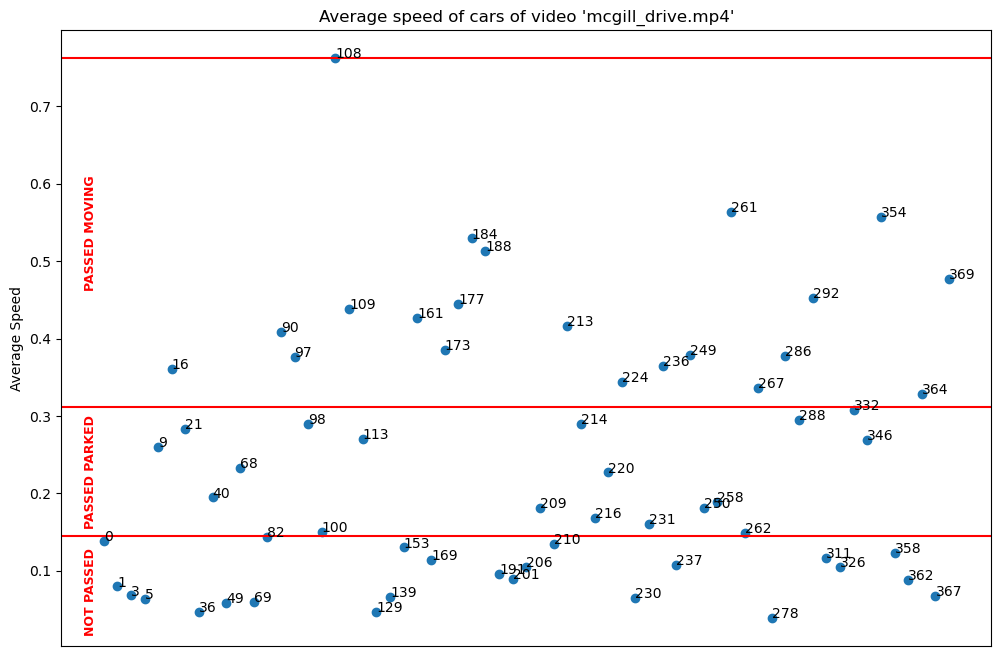

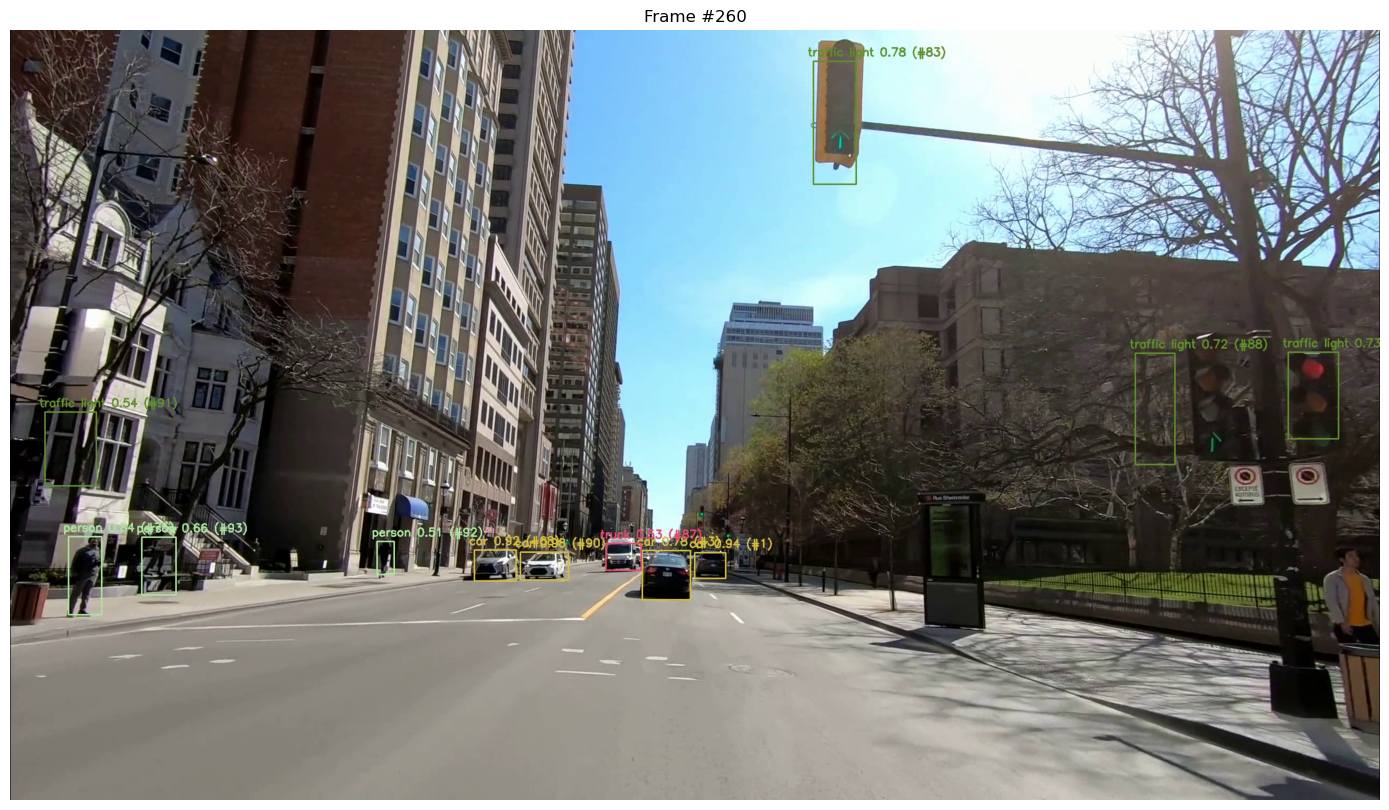

INFO ON FRAME #260
| CARS MOVING IN OPPOSITE DIRECTION:
| Car #90	first_frame=249	last_frame=309

| CARS PARKED:
| Car #68	first_frame=193	last_frame=302

| PEDESTRIANS:
| Pedestrian #75	first_frame=216	last_frame=270
| Pedestrian #92	first_frame=252	last_frame=306

| SUMMARY FOR THE WHOLE VIDEO:
| Parked passed 18
| Moving passed 21
| Pedestrians passed 41



VIDEO: st-catherines_drive.mp4


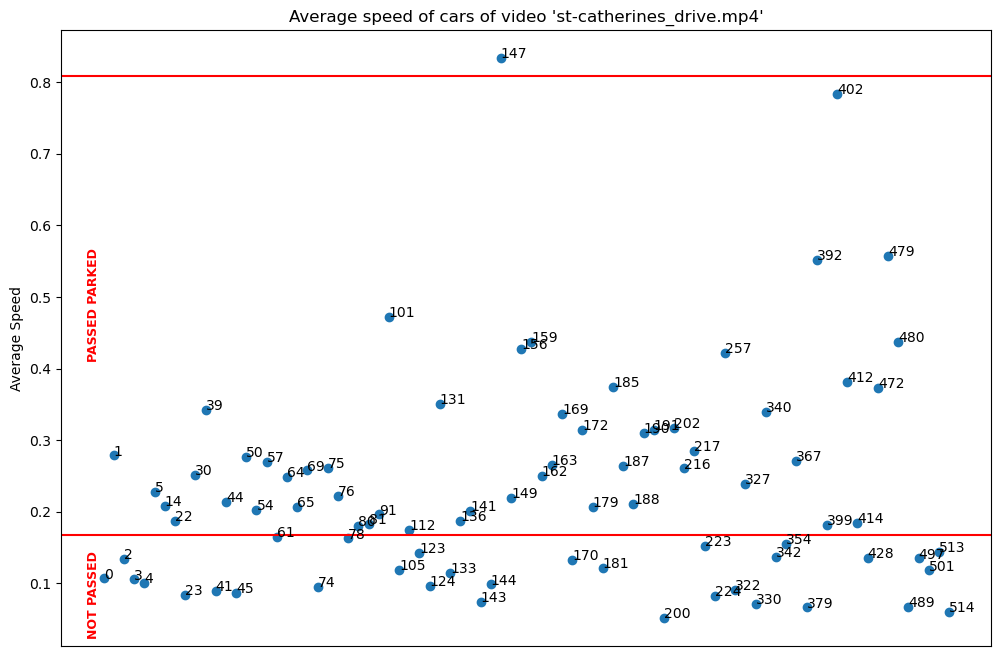

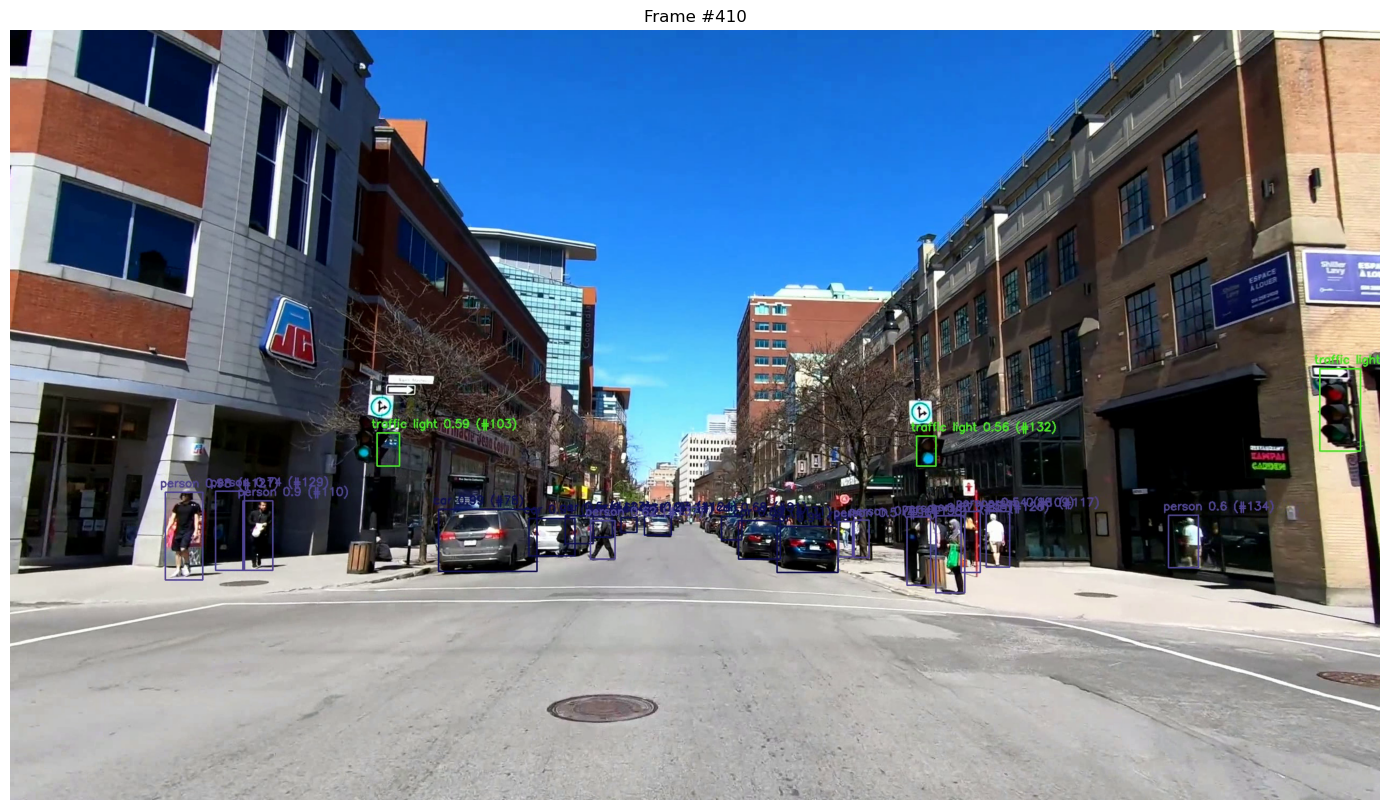

INFO ON FRAME #410
| CARS MOVING IN OPPOSITE DIRECTION:

| CARS PARKED:
| Car #81	first_frame=269	last_frame=557
| Car #91	first_frame=314	last_frame=438
| Car #112	first_frame=368	last_frame=576
| Car #131	first_frame=402	last_frame=498
| Car #136	first_frame=405	last_frame=445

| PEDESTRIANS:
| Pedestrian #96	first_frame=343	last_frame=415
| Pedestrian #99	first_frame=348	last_frame=416
| Pedestrian #109	first_frame=364	last_frame=433
| Pedestrian #110	first_frame=366	last_frame=417
| Pedestrian #117	first_frame=378	last_frame=461
| Pedestrian #121	first_frame=385	last_frame=425
| Pedestrian #126	first_frame=392	last_frame=465
| Pedestrian #129	first_frame=395	last_frame=433
| Pedestrian #138	first_frame=410	last_frame=480

| SUMMARY FOR THE WHOLE VIDEO:
| Parked passed 51
| Moving passed 1
| Pedestrians passed 120





In [15]:
objects_ids_position_dict : dict[str, dict[int, ObjectTracker]] = {
    video_name: compute_video_objects_displacement(frames_objects_dict)
    for video_name, frames_objects_dict in video_frames_objects_dict.items()
}

# Frame to showcase for each of the two videos
frame_to_display: dict[str, int] = {
    video_names[0]: 260,
    video_names[1]: 410
}

# Apply mean-shift clustering to both videos and display results
for video_name, objects_position in objects_ids_position_dict.items():
    print(f"VIDEO: {video_name}")

    # Apply mean-shift clustering and display data
    cluster_centers = apply_meanshift_clustering(objects_position)
    show_clustering(cluster_centers, objects_position)

    # Get data on objects we pass
    parked_passed, moving_passed, pedestrians_passed = get_passed_objects_data(cluster_centers, objects_position)


    # Display frame #260 with data to showcase that our algorithm works
    video_out = VideoReader(PATH + "/out/" + video_name)
    display_frame_with_data(video_out, frame_to_display[video_name], parked_passed, moving_passed, pedestrians_passed)
    video_out.release()

    # Print number of passed objects
    print("| SUMMARY FOR THE WHOLE VIDEO:")
    print(f"| Parked passed {len(parked_passed)}")
    print(f"| Moving passed {len(moving_passed)}")
    print(f"| Pedestrians passed {len(pedestrians_passed)}")
    print()
    print()
    print("=" * 50 + "\n")

## Results & Discussion
### Results
We construct the tables below, showing the number of (parked and moving) cars and pedestrians passed, as both detected by our program and manually counted. We do this for both videos

Video: `mcgill_drive.mp4`

| Class              | Detected by program | Manually counted |
|--------------------| --------------------| ---------------  |
| Parked Cars Passed | 18                  | 14               |
| Moving Cars Passed | 21                  | 23               |
| Pedestrians Passed | 41                  | 36               |


Video: `st-catherines_drive.mp4`

| Class              | Detected by program | Manually counted |
|--------------------| --------------------| ---------------  |
| Parked Cars Passed | 51                  | 56               |
| Moving Cars Passed | 1                   | 0                |
| Pedestrians Passed | 120                 | 97               |

### Performance
There is no definite way to define a goal for performance. However, one obvious way to do so, is to aim for our algorithm to be able to run in real-time, on a live video feed.

Unfortunately, our algorithm does not meet this requirement, and is actually pretty slow. However, we experimented with a different approach to improve this.
Indeed, we experimented with skipping frames and tried to use every other frame, and every 5 frames. As expected this results in a decrease in the accuracy of the our results, and can even mess with the clustering of data.

Therefore, it is up to the user to choose a balance between the desired accuracy and the speed of execution. However, once the clustering is affected, damage is beyond acceptable.

### Problems
While our program's accuracy is robust as seen in the results and as explained in the section above, it does have a few limitiations.

1. Tracking:
    - Since the detection often detects "fake" objects, as in, YOLOv3 often wrongfully detects objects in some areas, the program is forced to drop some objects which appeared in little number of frames. By dropping these objects however, the program also drops some "real" objects which, while appeared briefly in the video, are still valid and should be counted. This is what happened multiple times in the video, and explains why some pedestrians or cars are not counted as passed although they are recognized by YOLOv3.
    - Another one of our main problems with tracking is the fact that when an object passes in front of another one, the hidden object is removed from the scene, and when it reappears a new object is created for it, instead of recognizing that it is the same. This is a very difficult problem to solve and we feel it is out of the scope of the project. We leave it as one of the potential improvements.

2. Clustering:
    - While we attempt to account for the depth and "real" distance of cars to the reference car, our estimation is far from perfect. It is a mathematically complicated problem which is out of the scope of the project. Therefore, we approximated this function as best we could but it could be greatly improved. We leave this problem as a potential improvement in the future.
    - Our approach at classifying the detected cars, which is running Meanshift clustering, is currently very sensitive to the changes in depth and direction of moving cars. An improvement for that would be to use stationary objects in the scene, such as traffic lights or trees, to compute the relative movement to these objects. That would give us a better approximation of the state of cars (moving, parked) in the scene.